In [11]:
from icecream import ic
import pandas as pd
from dateutil.relativedelta import relativedelta
# from dhs_pca_functions import *
# from pandarallel import pandarallel
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split


from tensorflow.keras.optimizers import Adam
%matplotlib inline
# Initialization
# pandarallel.initialize()

In [12]:
# folder: path = "/mnt/datadisk/data/surveys/DHS_final_raw_data/"
# work_dir = "/mnt/datadisk/data/Projects/water/pickles/"
input_dir = "/mnt/datadisk/data/Projects/water/inputs/"
# min_version = 3
overwrite_pqt = True
# parquet = False
# use_dask = False
# drop_threshold = False
# drop_col_counter = False
# cols_to_load_simultaneously = 10
dataset_type = 'HR'  #, 'BR', 'CR', 'HW', 'IR', 'KR', 'MR', 'PR', 'AR'] ??['AN', 'FC, 'FP', 'HW', 'PV', 'SC'] < 25 surveys
# add_str = 'pd'
# columns = []
# verbose = False
# available_since_v = 7
# preprocessing_answers_file = f"{input_dir}summary_df_V3_{dataset_type}__unify_answers_reviewed2b.csv"
# out_f = f"{input_dir}DF_V3_{dataset_type}_after_replacing.pkl"
# preprocessing_f = f"{input_dir}Preprocessing_df_V3_{dataset_type}_unified.pkl"
# unify_columns_f = f"{input_dir}summary_df_V3_{dataset_type}_unify_cols_reviewed.csv"
# numeric_in_f = f"{input_dir}grouped_df_V3_{dataset_type}_numeric.pkl"
# string_in_f = f"{input_dir}grouped_df_V3_{dataset_type}_string.pkl"
# fewsNet_f = f"{input_dir}fewsnet_gaul_adm2.csv"

# numeric_out_f = f"{input_dir}grouped_df_V3_{dataset_type}_numeric_joined_with_ipc.pkl"
# string_out_f = f"{input_dir}grouped_df_V3_{dataset_type}_string_joined_with_ipc.pkl"
add_str = '_w_NANs'
group_by_col = 'adm2_gaul'
out_f = f"{input_dir}grouped_df_V3_{dataset_type}_{group_by_col}_joined_with_ipc{add_str}.pkl"
scale_numerical_data = True

# numeric_in_f = f"{input_dir}grouped_df_V3_{dataset_type}_numeric_joined_with_ipc_w6-7y.pkl"
# string_in_f = f"{input_dir}grouped_df_V3_{dataset_type}_string_joined_with_ipc_w6-7y.pkl"
# cut_perc = 10
in_f = f"{input_dir}grouped_df_V3_{dataset_type}_{group_by_col}_joined_with_ipc{add_str}.pkl"
# input_df = f"{input_dir}grouped_df_V3_{dataset_type}_string_numeric_combined.pkl"

In [13]:
input_df = pd.read_pickle(in_f)
for col in input_df.columns:
    print(col)

Meta; GEID_init
Meta; adm2_gaul
Meta; adm1_gaul
Meta; adm0_gaul
Meta; year
Meta; month
Meta; date
DHS Num; number of household members: mean
DHS Num; number of household members: median
DHS Num; number of household members: std
DHS Num; number of household members: skewness
DHS Cat; number of household members: <lambda_1>
DHS Num; owns sheep: mean
DHS Num; owns sheep: median
DHS Num; owns sheep: std
DHS Num; owns sheep: skewness
DHS Cat; owns sheep: <lambda_1>
DHS Num; number of eligible children for height and weight: mean
DHS Num; number of eligible children for height and weight: median
DHS Num; number of eligible children for height and weight: std
DHS Num; number of eligible children for height and weight: skewness
DHS Cat; number of eligible children for height and weight: <lambda_1>
DHS Num; total adults measured: mean
DHS Num; total adults measured: median
DHS Num; total adults measured: std
DHS Num; total adults measured: skewness
DHS Cat; total adults measured: <lambda_1>
DHS

In [14]:
def retrieve_ds(df, drop_meta=False, drop_6_7_y_FS=True, drop_food_help=True, drop_IPC_wo_food_help=False, drop_perc=65, drop_region=False, 
                drop_languages=['language of interview', 'native language', 'language of questionnaire'],
                IPC_mode='mean', drop_20_25_y_FS=True, use_short_long_FS_time_spans='long', numerical_data=['mean', 'median', 'std', 'skewness'], 
                use_NAN_amount_and_replace_NANs_in_categorical=True, remain_year=True, remain_month=True, 
                remain_adm=['adm0_gaul', 'adm1_gaul', 'adm2_gaul'], remain_GEID_init=True,
                verbose=3):
    df_in = df.copy()
    incoming_cols = df.columns.tolist()
    if drop_meta:
        remaining_inds = []
        if use_NAN_amount_and_replace_NANs_in_categorical:
            remaining_inds.append(': NaN')
        if remain_year:
            remaining_inds.append('year')
        if remain_month:
            remaining_inds.append('month')
        if remain_GEID_init:
            remaining_inds.append('GEID_init')
        if remain_adm:
            remaining_inds += remain_adm
        if not remaining_inds:
            cols = [c for c in df.columns if 'Meta; ' in c]# and not 'year' in c]
        else:
            cols = [c for c in df.columns if 'Meta; ' in c and not any(ind in c for ind in remaining_inds) or 'percentage of valid answers' in c]
        df.drop(columns=cols, inplace=True)
        drop_meta_cols = cols
    if drop_6_7_y_FS:
        cols = [c for c in df.columns if '6-7y' in c and 'IPC' in c]
        df.drop(columns=cols, inplace=True)
    if drop_20_25_y_FS:
        cols = [c for c in df.columns if '20-25y' in c and 'FS; IPC' in c]
        df.drop(columns=cols, inplace=True)
    if drop_food_help:
        cols = [c for c in df.columns if 'FS; IPC + FH:' in c]
        df.drop(columns=cols, inplace=True)
    if drop_IPC_wo_food_help:
        cols = [c for c in df.columns if 'FS; IPC:' in c]
        df.drop(columns=cols, inplace=True)
    if use_NAN_amount_and_replace_NANs_in_categorical:
        cols = [c for c in df.columns if 'DHS Cat;' in c]
        df[cols] = df[cols].fillna(0.0)
    if drop_perc:
        cols = [c for c in df.columns if len(df[c].dropna()) / len(df[c]) * 100 < drop_perc and not 'FS; IPC' in c]
        df.drop(columns=cols, inplace=True)
        drop_perc_cols = cols
    if drop_region:
        cols = [c for c in df.columns if 'DHS Cat; region:' in c]
        df.drop(columns=cols, inplace=True)
    if drop_languages:
        cols = [c for c in df.columns if any([lang in c for lang in drop_languages])]
        df.drop(columns=cols, inplace=True)
    if IPC_mode:
        cols = [c for c in df.columns if 'FS; IPC' in c and not IPC_mode in c]
        df.drop(columns=cols, inplace=True)
    if use_short_long_FS_time_spans == 'long':
        long_strs = ['0-5m', '6-12m', '1-2y', '2-4y', '4-6y', '6-7y', '6-10y', '10-15y', '15-20y', '20-25y']
        cols = [c for c in df.columns if 'FS; IPC' in c and any([s in c for s in long_strs])]
        df.drop(columns=cols, inplace=True)
    if use_short_long_FS_time_spans == 'short':
        short_strs = ['0-1y', '0-2y', '2-6y', '6-12y', '12-20y']
        cols = [c for c in df.columns if 'FS; IPC' in c and any([s in c for s in short_strs])]
        df.drop(columns=cols, inplace=True)
    if numerical_data:
        cols = [c for c in df.columns if 'DHS Num;' in c and not any([s in c for s in numerical_data])]
        df.drop(columns=cols, inplace=True)
    
    if verbose:
        num_dropped = set(['mean', 'median', 'std', 'skewness']).difference(numerical_data)
        print(f'Dropped {len(incoming_cols) - len(df.columns)}, remaining columns: {len(df.columns)}')
        print(f'Dropped following subsets of numerical data: {num_dropped}')
        print(f'Retained following subsets of food security data: \n   {IPC_mode} \n   {use_short_long_FS_time_spans} time spans.\nDropped 6-7y {drop_6_7_y_FS} \n    20-25y {drop_20_25_y_FS}\n'
              f'Dropped: food help {drop_food_help}\n    IPC w/o food help {drop_IPC_wo_food_help}')
        print(f'Dropped meta data {drop_meta} and region {drop_region}')
        print(f'Dropped columns with less than {drop_perc}% of available values')
        
        if verbose > 1:
            seen = set()
            for c in drop_meta_cols:
                print('Dropped meta:', c)
            
            for c in drop_perc_cols:
                c_base = c
                if ': ' in c_base:
                    c_base = c.rsplit(': ', 1)[0]
                if c_base not in seen:
                    print(f'Dropped perc: {c_base}: {len(df_in[c].dropna()) / len(df_in[c]) * 100}%')
                    seen.add(c_base)
            
        if verbose > 2:
            print('Remaining columns:')
            for c in df.columns:
                print(f'Remaining: {c}: {round(len(df_in[c].dropna()) / len(df_in[c]) * 100, 1)}%')
            

    return df

df = retrieve_ds(input_df, drop_meta=True, drop_food_help=True, drop_IPC_wo_food_help=False, drop_perc=65, drop_region=False, 
                 drop_languages=['language of interview', 'native language', 'language of questionnaire'], 
                 use_NAN_amount_and_replace_NANs_in_categorical=True, verbose=3)

df.to_csv(f"{input_dir}grouped_df_V3_{dataset_type}_{group_by_col}_joined_with_ipc{add_str}_chgpt.csv")

Dropped 687, remaining columns: 910
Dropped following subsets of numerical data: set()
Retained following subsets of food security data: 
   mean 
   long time spans.
Dropped 6-7y True 
    20-25y True
Dropped: food help True
    IPC w/o food help False
Dropped meta data True and region False
Dropped columns with less than 65% of available values
Dropped meta: Meta; date
Dropped meta: Meta; amount of households
Dropped meta: Meta; GEID: percentage of valid answers
Dropped meta: Meta; adm1_gaul: percentage of valid answers
Dropped meta: Meta; adm0_gaul: percentage of valid answers
Dropped meta: Meta; year: percentage of valid answers
Dropped meta: Meta; month: percentage of valid answers
Dropped meta: Meta; household number: percentage of valid answers
Dropped meta: Meta; cluster number: percentage of valid answers
Dropped meta: Meta; date: percentage of valid answers
Dropped meta: Meta; number of household members: percentage of valid answers
Dropped meta: Meta; owns sheep: percentage 

In [15]:
# Define RMSE
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 


In [16]:
label_df = df[[c for c in df.columns if 'FS; IPC' in c]]
input_df2 = df.drop(columns=[c for c in df.columns if 'FS; IPC' in c])
num_cols = [c for c in input_df2.columns if 'DHS Num;' in c]
from keras.callbacks import ModelCheckpoint

label_cols = [c for c in df.columns if 'FS; IPC' in c]
scaler_l = []
history_l = []
y_test_l = []
y_pred_l = []
model_l = []
amount_inputs = []
amount_cols = []

for nr, col in enumerate(label_cols):

    print(nr, col, len(df[col]))
    labels = df[col]
    labels = labels.dropna()
    # labels = labels[labels < 4]
    labels_ind = labels.index
    # scale the labels
    scaler = StandardScaler()
    labels = scaler.fit_transform(labels.values.reshape(-1, 1))
    labels = pd.Series(labels.flatten(), index=labels_ind)
    input_df = input_df2.loc[labels.index]
    print(len(labels), len(input_df))
    #drop NaNs
    input_df = input_df.dropna(axis=0)
    input_ind = input_df.index
    labels = labels.loc[input_ind]
    print('lens', len(labels), len(input_df))
    print('cols', len(input_df.columns))
    if len(input_df) < 100:
        continue
    amount_cols.append(len(input_df.columns))
    amount_inputs.append(len(input_df))
    assert(labels.index.equals(input_df.index))
    amount_inputs.append(len(input_df))
    scaler_l.append(scaler)
    
    if scale_numerical_data:
        scaler2 = StandardScaler()
        input_df[num_cols] = scaler2.fit_transform(input_df[num_cols])
        
    # assert labels.index.equals(input_df.index)
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(input_df, labels, test_size=0.15, random_state=42)

    # Further split the training data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)  # 0.25 x 0.8 = 0.2

    X_train = X_train.astype('float32')
    y_train = y_train.astype('float32')
    X_val = X_val.astype('float32')
    y_val = y_val.astype('float32')
    X_test = X_test.astype('float32')
    y_test = y_test.astype('float32')
    
    # Define the model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[root_mean_squared_error])

    # Define the ModelCheckpoint callback
    checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint])
    history_l.append(history)
    
    # Load the best model
    model.load_weights('best_model.h5')
    
    model_l.append(model)
    # Evaluate the model on the test set
    test_loss, test_rmse = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss}')
    print(f'Test RMSE: {test_rmse}')

    # Predict on the test set
    y_pred = model.predict(X_test)
    y_test_l.append(y_test)
    y_pred_l.append(y_pred)

0 FS; IPC: 0-1y: mean 15252
5635 5635
lens 4813 4813
cols 905


ValueError: could not convert string to float: 'NGGE6AFL'

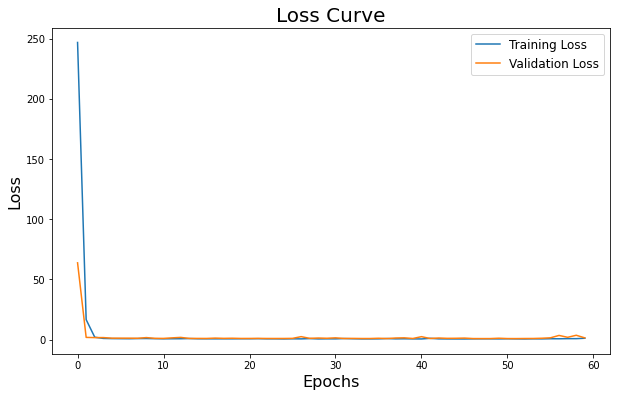

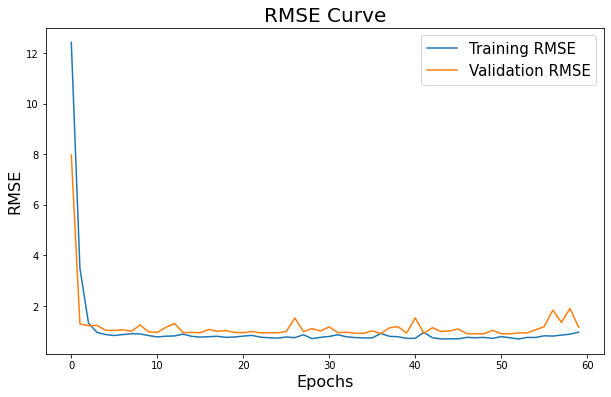

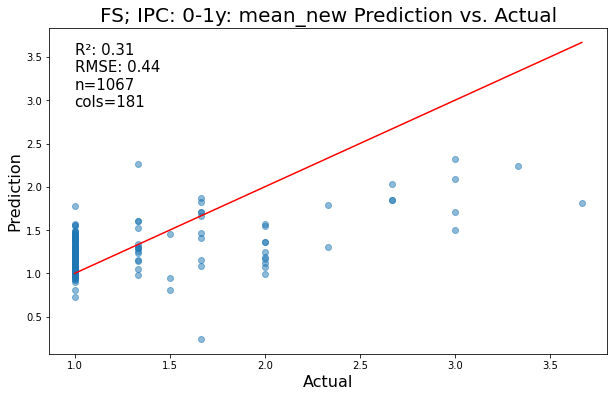

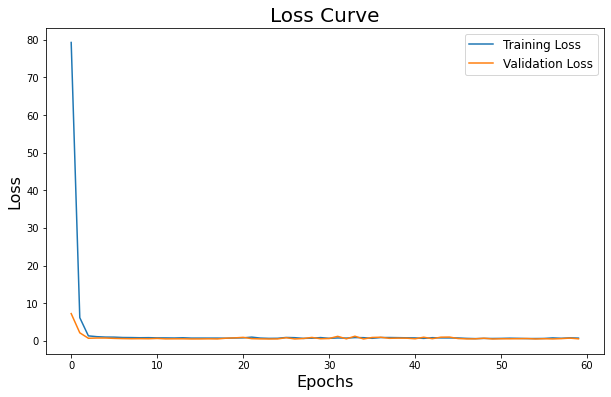

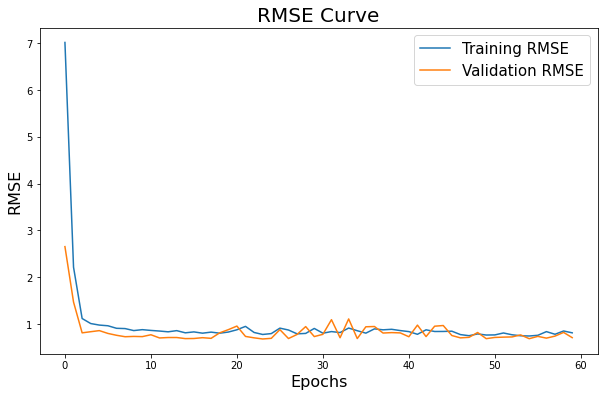

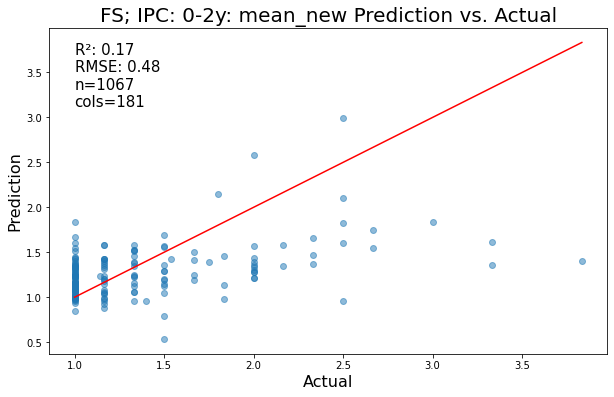

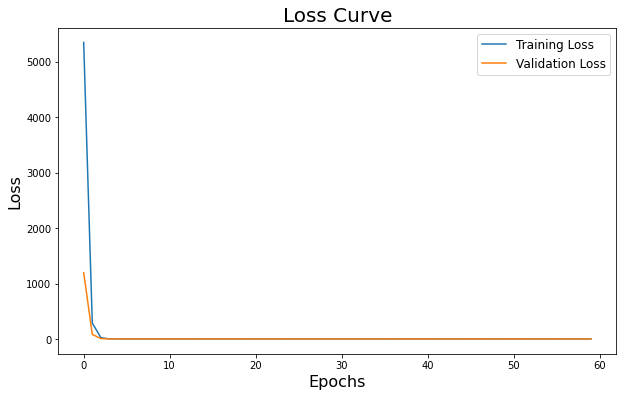

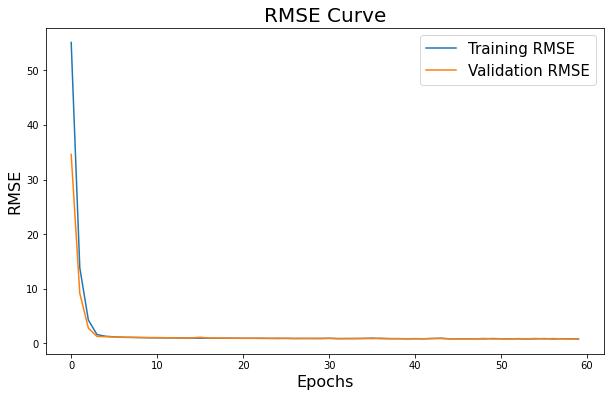

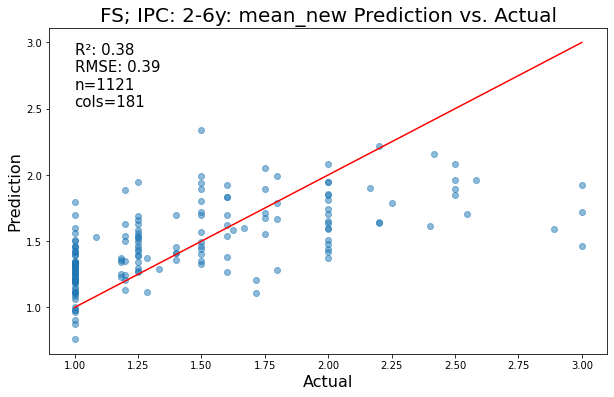

In [ ]:
dic = {}
for name, history, scaler, y_test, y_pred, amount_input, amount_col in zip(label_cols, history_l, scaler_l, y_test_l, y_pred_l, amount_inputs, amount_cols):
    # Loss curve
    name += '_new'
    plt.figure(figsize=(10, 6), facecolor='white')
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve', fontsize=20)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(fontsize=12)
    plt.savefig(f"{input_dir}loss_curve_{name}.png")

    plt.figure(figsize=(10, 6), facecolor='white')
    plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
    plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
    plt.title('RMSE Curve', fontsize=20)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('RMSE', fontsize=16)
    plt.legend(fontsize=15)
    plt.savefig(f"{input_dir}rmse_curve_{name}.png")

    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test.to_numpy().reshape(-1, 1))
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    dic[name] = [round(r2, 3), round(rmse, 3), amount_input, amount_col]

    plt.figure(figsize=(10, 6), facecolor='white')
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('Actual', fontsize=16)
    plt.ylabel('Prediction', fontsize=16)
    plt.title(f'{name} Prediction vs. Actual', fontsize=20)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
    plt.text(min(y_test), max(y_test), f'R²: {r2:.2f}\nRMSE: {rmse:.2f}\nn={amount_input}\ncols={amount_col}', verticalalignment='top', horizontalalignment='left', backgroundcolor='white', fontsize=15)
    plt.savefig(f"{input_dir}Scatterplot_{name.replace(':', '')}.png")
    

In [ ]:
summary_df = pd.DataFrame(dic).T
summary_df.columns = ['R²', 'RMSE', 'n', 'input cols']
summary_df

,R²,RMSE,n,input cols
FS; IPC: 0-1y: mean_new,0.308,0.442,1067.0,181.0
FS; IPC: 0-2y: mean_new,0.170,0.485,1067.0,181.0
FS; IPC: 2-6y: mean_new,0.384,0.387,1121.0,181.0


In [ ]:
for model, name, scaler in zip(model_l, label_cols, scaler_l):
    print('MZGE7AFL' in meta_df['GEID_init'].values)
    meta_ind = meta_df[meta_df['GEID_init'] == 'MZGE7AFL'].index
    input_df = input_df2.loc[meta_ind]
    # Predict on the test set
    y_pred = model.predict(input_df)

    # Inverse transform y_pred
    y_pred_actual = scaler.inverse_transform(y_pred)
    # Convert y_pred_actual to a series
    y_pred_actual_series = pd.Series(y_pred_actual.flatten(), index=meta_ind)

    moz_df = pd.concat([meta_df.loc[meta_ind], pd.DataFrame(y_pred_actual_series, columns=[name])], axis=1)
    moz_df.to_csv(f"{input_dir}predicted_{name}.csv")

NameError: name 'meta_df' is not defined

In [ ]:
meta_df['GEID_init'].value_counts().head(50)

NameError: name 'meta_df' is not defined